In [1]:
import os
os.chdir("../..")

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent
from shell.fleet.data.send_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
seed_everything(0)

In [4]:
use_contrastive = True
num_tasks = 4

data_cfg = {
    "dataset_name": "mnist",
    "num_tasks": num_tasks,
    "num_train_per_task": 128,
    "num_val_per_task": 102,
    'remap_labels': True,
    'use_contrastive': use_contrastive,
}
dataset = get_dataset(**data_cfg)

INFO:root:Class sequence: [5 0 3 4 2 6 7 1 8 9]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


In [5]:
seed_everything(7)
sender_dataset = get_dataset(**data_cfg)

INFO:root:Class sequence: [9 5 7 8 4 3 6 1 0 2]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)


In [6]:
net_cfg = {
    'depth': 4,
    'layer_size': 64,
    'num_init_tasks': num_tasks,
    'i_size': 28,
    'num_classes': 2,
    'num_tasks': 4,
    'dropout': 0.0,
}

agent_cfg = {
    'memory_size': 64,
    'use_contrastive': use_contrastive,
    'save_dir': 'test',
}

In [7]:
NetCls = MLPSoftLLDynamic
LearnerCls = CompositionalDynamicER
sharing_cfg = DictConfig({
    "scorer": "cross_entropy",
    "num_queries": 4,
    "query_score_threshold": 0.0,
})
train_cfg = {
    # "num_epochs": 40,
    "num_epochs": 1,
}

agent = RecvDataAgent(0, 0, dataset,
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                sharing_cfg)

sender = RecvDataAgent(1, 1, sender_dataset,
                NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, 
                sharing_cfg)



INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1001


In [8]:
Xval, yval = agent.dataset.valset[0].tensors
print(Xval.shape)

torch.Size([102, 1, 28, 28])


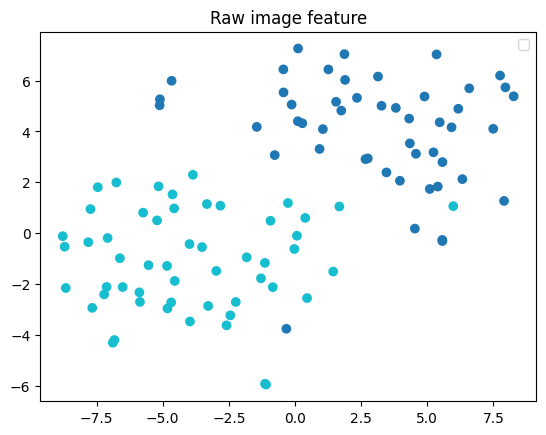

In [9]:
# plot Xval on 2D using t-SNE and label with yval

Xval_embedded = TSNE(n_components=2, random_state=0).fit_transform(Xval.reshape(Xval.shape[0], -1))

plt.scatter(Xval_embedded[:, 0], Xval_embedded[:, 1], c=yval, cmap='tab10');
plt.legend()
plt.title("Raw image feature");

In [10]:
Xval.device

device(type='cpu')

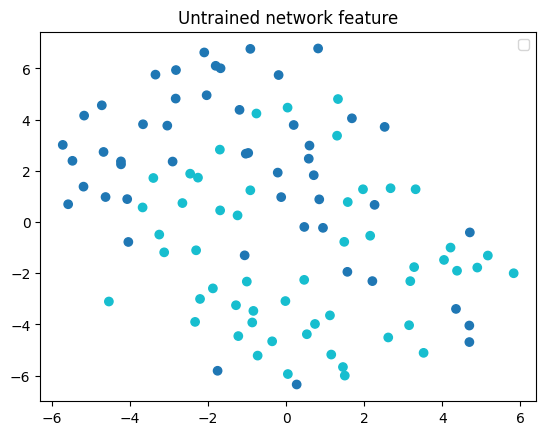

In [11]:
with torch.no_grad():
    agent.net.eval()
    Xval_untrain_embed = agent.net.encode(Xval.to(agent.net.device), task_id=0).detach().cpu()
    Xval_untrain_embedded = TSNE(n_components=2, random_state=0).fit_transform(Xval_untrain_embed)

agent.net.train()
plt.scatter(Xval_untrain_embedded[:, 0], Xval_untrain_embedded[:, 1], c=yval, cmap='tab10')
plt.legend()
plt.title("Untrained network feature");

In [12]:
for t in range(num_tasks):
    agent.train(t)
    sender.train(t)

INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.692	acc: 0.524
INFO:root:	task: avg	loss: 0.692	acc: 0.524
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.692	acc: 0.524
INFO:root:	task: avg	loss: 0.692	acc: 0.524
INFO:root:final components: 4
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.692	acc: 0.531
INFO:root:	task: avg	loss: 0.692	acc: 0.531
INFO:root:epochs: 0, training task: 0
INFO:root:	task: 0	loss: 0.692	acc: 0.531
INFO:root:	task: avg	loss: 0.692	acc: 0.531
INFO:root:final components: 4
INFO:root:epochs: 0, training task: 1
INFO:root:	task: 0	loss: 0.692	acc: 0.524
INFO:root:	task: 1	loss: 0.694	acc: 0.493
INFO:root:	task: avg	loss: 0.693	acc: 0.508
INFO:root:epochs: 0, training task: 1
INFO:root:	task: 0	loss: 0.692	acc: 0.524
INFO:root:	task: 1	loss: 0.694	acc: 0.493
INFO:root:	task: avg	loss: 0.693	acc: 0.508
INFO:root:final components: 4
INFO:root:epochs: 0, training task: 1
INFO:root:	task: 0	loss: 0.692	acc: 0.531
IN

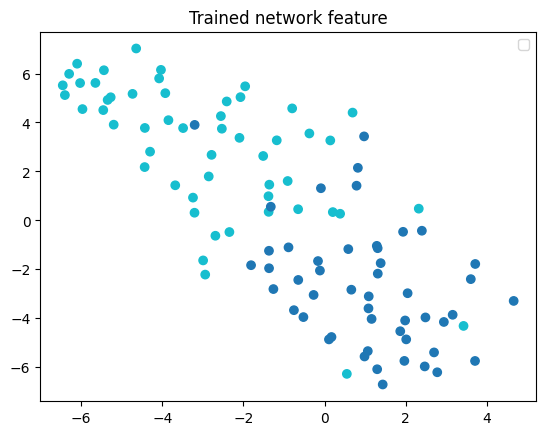

In [13]:
with torch.no_grad():
    agent.net.eval()
    Xval_train_embed = agent.net.encode(Xval.to(agent.net.device), task_id=0).detach().cpu()
    Xval_train_embedded = TSNE(n_components=2, random_state=0).fit_transform(Xval_train_embed)

agent.net.train()
plt.scatter(Xval_train_embedded[:, 0], Xval_train_embedded[:, 1], c=yval, cmap='tab10')
plt.legend()
plt.title("Trained network feature");

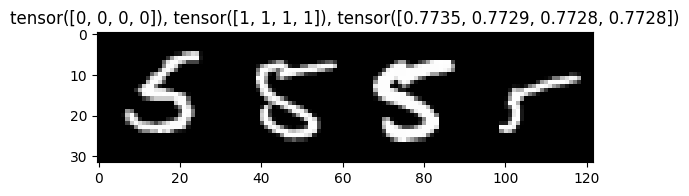

In [14]:
qX, qY, ypred, scores = agent.compute_query(task_id=0, mode="current", debug_return=True)
qX = qX[0]
qY = qY[0]
ypred = ypred[0]
scores = scores[0]

q_plt = make_grid(qX)
plt.imshow(q_plt.permute(1, 2, 0))
# plotting the query
plt.title(f"{qY}, {ypred}, {scores}");

In [15]:
Xval_train_embed.shape

torch.Size([102, 64])

In [16]:
yval.shape

torch.Size([102])

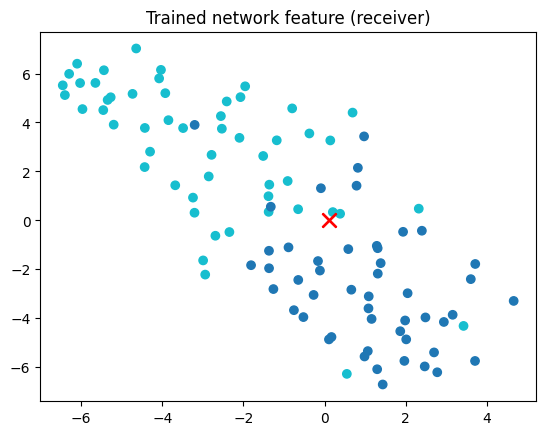

In [17]:
# plot the embedding with the query point ("hard" points)
with torch.no_grad():
    agent.net.eval()
    Xval_train_embed = agent.net.encode(Xval.to(agent.net.device), task_id=0).detach().cpu()
    qX_embed = agent.net.encode(qX.to(agent.net.device), task_id=0).detach().cpu()
    Xval_train_embedded = TSNE(n_components=2, random_state=0).fit_transform(Xval_train_embed)

agent.net.train()
plt.scatter(Xval_train_embedded[:, 0], Xval_train_embedded[:, 1], c=yval, cmap='tab10')
plt.scatter(qX_embed[:, 0], qX_embed[:, 1], c='r', marker='x', s=100)
plt.title("Trained network feature (receiver)");

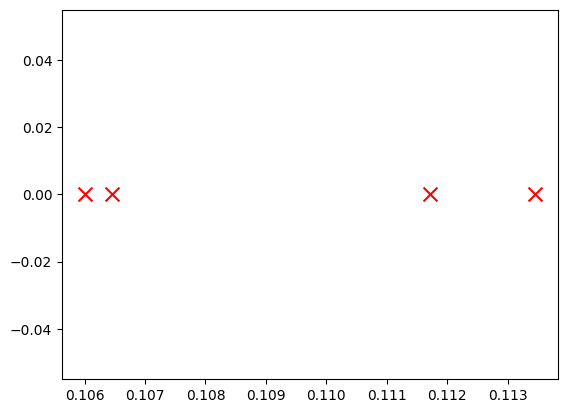

In [18]:
plt.scatter(qX_embed[:, 0], qX_embed[:, 1], c='r', marker='x', s=100);

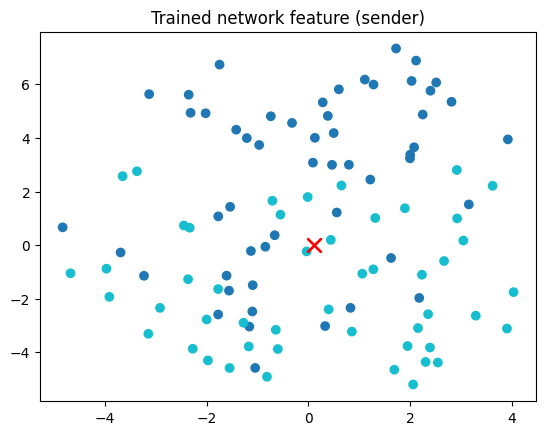

In [19]:
# plot the embedding with the query point ("hard" points)
with torch.no_grad():
    sender.net.eval()
    Xval_sender, yval_sender = sender.dataset.valset[0].tensors
    Xval_train_embed = sender.net.encode(Xval_sender.to(sender.net.device), task_id=0).detach().cpu()
    qX_embed = agent.net.encode(qX.to(sender.net.device), task_id=0).detach().cpu()
    Xval_train_embedded = TSNE(n_components=2, random_state=0).fit_transform(Xval_train_embed)

sender.net.train()
plt.scatter(Xval_train_embedded[:, 0], Xval_train_embedded[:, 1], c=yval_sender, cmap='tab10')
plt.scatter(qX_embed[:, 0], qX_embed[:, 1], c='r', marker='x', s=100)
plt.title("Trained network feature (sender)");

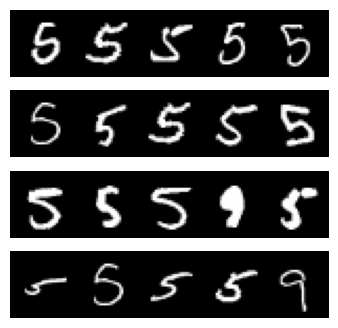

In [29]:
# neighbors = agent.nearest_neighbors(qX, neighbors=5, tasks=[0]) # (num_X, num_neighbors, 1, 28, 28)
neighbors = sender.nearest_neighbors(qX, neighbors=5,
                                     chosen_tasks=[0]) # (num_X, num_neighbors, 1, 28, 28)
# neighbors = sender.nearest_neighbors(qX, neighbors=5)
                                     
neigbors = neighbors.cpu()
neigbors = neighbors.cpu()
# plot the neighbors per row
n_X = neighbors.shape[0]
fig, ax = plt.subplots(n_X, 1, figsize=(20, 4))
for i in range(n_X):
    n_plt = make_grid(neighbors[i].cpu())
    ax[i].imshow(n_plt.permute(1, 2, 0))
    ax[i].axis('off')

In [21]:
sims_prefilter, Xs, ys, tasks = sender.compute_similarity(
            qX, 
            computer=sender.compute_raw_dist
        )

In [22]:
n_filter_neighbors = 10

X_n_prefilter, y_n_prefilter, task_neighbors_prefilter = sender.extract_topk_from_similarity(
            sims_prefilter, Xs, ys, tasks, 
            neighbors=n_filter_neighbors
        )

torch.Size([4, 10, 1, 28, 28])


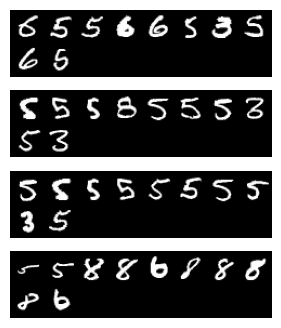

In [23]:
print(X_n_prefilter.shape)


n_X = X_n_prefilter.shape[0]
fig, ax = plt.subplots(n_X, 1, figsize=(20, 4))
for i in range(n_X):
    n_plt = make_grid(X_n_prefilter[i].cpu())
    ax[i].imshow(n_plt.permute(1, 2, 0))
    ax[i].axis('off')


torch.Size([4, 4, 1, 28, 28])


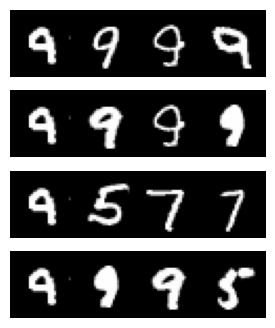

In [24]:
Xn = sender.new_nearest_neighbors(qX, n_neighbors=4, n_filter_neighbors=10)
print(Xn.shape)

n_X = Xn.shape[0]
fig, ax = plt.subplots(n_X, 1, figsize=(20, 4))
for i in range(n_X):
    n_plt = make_grid(Xn[i].cpu())
    ax[i].imshow(n_plt.permute(1, 2, 0))
    ax[i].axis('off')


In [25]:
qidx = []
for i, q in enumerate(qX):
    for idx, x in enumerate(Xval):
        if torch.equal(q, x):
            qidx.append(idx)
            break

In [26]:
Xval[qidx].shape

torch.Size([4, 1, 28, 28])

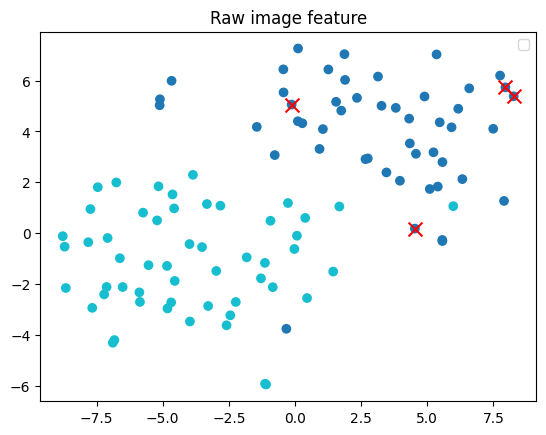

In [27]:
Xval_embedded = TSNE(n_components=2, random_state=0).fit_transform(Xval.reshape(Xval.shape[0], -1))

plt.scatter(Xval_embedded[:, 0], Xval_embedded[:, 1], c=yval, cmap='tab10');
plt.scatter(Xval_embedded[qidx, 0], Xval_embedded[qidx, 1], c='r', marker='x', s=100)
plt.legend()
plt.title("Raw image feature");